In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from tqdm import tqdm

In [2]:
location = [slice(240,255), slice(140,155)]
dates = np.arange(np.datetime64('1972-12-11','D'),np.datetime64('1977-05-11','D'))

# Brightness Temperatures

In [3]:
datadir = r"D:\N5ESMR\N5ESMR_out\ESACCI-SEAICE-L3C-SICONC-NIMBUS5_ESMR-EASE2_LDTPcorrected_NH-fv1.1"
files = sorted(glob(datadir + r"\*.nc"))
ds = xr.open_mfdataset(files, combine='by_coords', engine ="netcdf4")

In [4]:
Tb = np.nanmean(ds["Tb_corr"][:,location[0],location[1]].to_numpy(),axis=(1,2))
time = ds["time"].to_numpy()
time = time.astype('datetime64[D]')

C:\Users\emilt\AppData\Local\Temp\ipykernel_11732\2519998224.py:1: RuntimeWarning: Mean of empty slice
  Tb = np.nanmean(ds["Tb_corr"][:,location[0],location[1]].to_numpy(),axis=(1,2))


# ITP for LDTP

In [5]:
ITPdir = r"C:\Users\emilt\Documents\Noter\N5_ESMR\N5ESMR_processing\tests_etc\ITP"
files = sorted(glob(ITPdir + r"\LDTP_NH_*.npy"))
ITPdates = sorted([np.datetime64(f[-14:-4], 'D') for f in files])
ITP = np.zeros(len(time))
i = 0
for t in tqdm(time):
    if t in ITPdates:
        idx = ITPdates.index(t)
        data = np.load(files[idx])
        ITP[i]= np.nanmean(data[location[0], location[1]])
    else:
        ITP[i] = np.nan
    i += 1


100%|██████████| 1136/1136 [00:12<00:00, 89.26it/s]


# Kolbe et al. ITP

In [6]:
import os
import json
TPDIR = 'C:/Users/emilt/Documents/Noter/N5_ESMR/N5ESMR_processing/outputs/newTP15'
ITP_name = 'arctic_ice'
OTP_name = 'arctic_ocean'

def loadTiePointFile(date, ITP_name, OTP_name):
    date = str(date)
    year = date[:4]
    month = date[5:7]
    day = date[8:10]

    # locating file
    filename = "Nimbus5-ESMR_%sm%s%s.json" % (year, month, day)
    file = os.path.join(TPDIR, filename)
    if os.path.exists(file):
        TP_data = json.load(open(file))
        OTP = TP_data[OTP_name]['mean_Tb_corr']
        OTP_std = TP_data[OTP_name]['std_Tb_corr']
        ITP = TP_data[ITP_name]['mean_Tb_corr']
        ITP_std = TP_data[ITP_name]['std_Tb_corr']
    
    # adding nan if file does not exist (given script this should never happen)
    else:
        OTP = np.nan
        OTP_std = np.nan
        ITP = np.nan
        ITP_std = np.nan
    
    return ITP, OTP, ITP_std, OTP_std

In [7]:
files = sorted(glob(TPDIR + "/*.json"))
TPdates = sorted([np.datetime64(f[-14:-10] + '-' + f[-9:-7] + '-' + f[-7:-5], 'D') for f in files])
ITP_kolbe = np.zeros(len(time))
OTP_kolbe = np.zeros(len(time))
i = 0
for t in tqdm(time):
    if t in TPdates:
        ITP_kolbe[i],OTP_kolbe[i],_,_ = loadTiePointFile(t,ITP_name,OTP_name)

    i += 1

100%|██████████| 1136/1136 [00:09<00:00, 118.88it/s]


# to daterange

In [8]:
def replace_nans_with_interpolation(signal):
    # Create an array of indices where NaN values are present
    nan_indices = np.isnan(signal)

    if np.all(nan_indices):
        return signal

    # Create an array of non-NaN indices
    non_nan_indices = np.arange(len(signal))

    mean = np.nanmean(signal)
    # Interpolate NaN values using non-NaN indices
    interpolated_values = np.interp(non_nan_indices, non_nan_indices[~nan_indices], signal[~nan_indices],left=mean,right=mean)

    # Replace NaN values with interpolated values in the original signal
    signal_with_interpolation = np.copy(signal)
    signal_with_interpolation[nan_indices] = interpolated_values[nan_indices]

    return signal_with_interpolation


def convert_to_daterange(array, cur_dates, new_dates, interp=False):

    assert new_dates[0]>=cur_dates[0] 
    assert new_dates[-1]<=cur_dates[-1]

    new_array = np.empty(len(new_dates))

 
    for i,date in enumerate(new_dates):
        if date in cur_dates:
            idx = np.where(cur_dates==date)
            new_array[i] = array[idx]
        else:
            new_array[i]= np.nan

    if interp:
        new_array = replace_nans_with_interpolation(new_array)
    return new_array



In [9]:
ITP_kolbe = convert_to_daterange(ITP_kolbe, time, dates, interp=True)
OTP_kolbe = convert_to_daterange(OTP_kolbe, time, dates, interp=True)
ITP = convert_to_daterange(ITP, time, dates, interp=True)
#Tb = convert_to_daterange(Tb, time, dates, interp=False)

C:\Users\emilt\AppData\Local\Temp\ipykernel_11732\3560763637.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_array[i] = array[idx]


# Plot

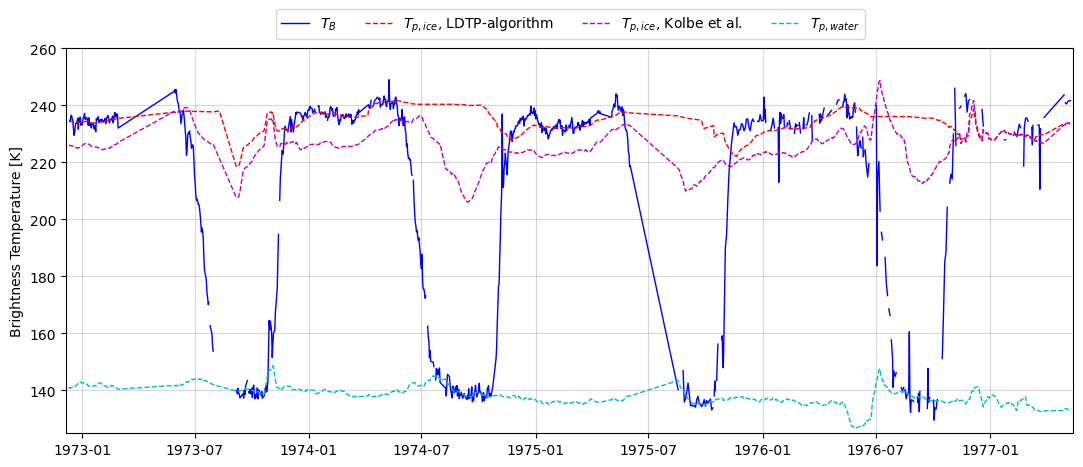

In [10]:
plt.figure(figsize=(13, 5))

plt.plot(time,Tb,'b-',linewidth=1,label='$T_B$')
plt.plot(dates,ITP,'r--',linewidth=1,label='$T_{p,ice}$, LDTP-algorithm')
plt.plot(dates,ITP_kolbe,'m--',linewidth=1,label='$T_{p,ice}$, Kolbe et al.')
plt.plot(dates,OTP_kolbe,'c--',linewidth=1, label='$T_{p,water}$')
plt.grid(alpha=0.5)
plt.xlim([dates[0]-5,dates[-1]+5])
plt.ylim([125,260])
plt.legend(ncol=4,bbox_to_anchor=(0.8, 1.12))
plt.ylabel('Brightness Temperature [K]')
plt.savefig('BaffinBay_sample_figure.pdf',bbox_inches='tight')